In [1]:
import os
os.chdir('../')

In [2]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [3]:
torch.cuda.set_device(2)

In [4]:
path_appfeat512 = path/'appian_features_384_album'
path_appfeat512_tst = path/'appian_tst_features_384_album'

In [5]:
dls_feat = get_3d_dls_feat(Meta.df_comb, path=path_appfeat512, bs=32, meta=True)

In [6]:
xb,yb = dls_feat.one_batch()
xb[0].shape, yb.shape

(torch.Size([32, 60, 2048]), torch.Size([32, 60, 6]))

## Model

In [7]:
class NeuralNet(nn.Module):
    def __init__(self, n_classes=6, embed_size=1024*2+1, LSTM_UNITS=1024*2+1, DO = 0.3):
        super(NeuralNet, self).__init__()
        
#         self.embedding_dropout = SpatialDropout(0.0) #DO)
#         self.flat = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten())
#         self.hook = ReshapeBodyHook(self.flat)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)

        self.linear = nn.Linear(LSTM_UNITS*2, n_classes)

    def forward(self, x):

#         x = torch.cat(x, axis=-1)
        x,pos = x
#         x = x.view(*x.shape[:2], -1, 4, 4)
        h_embedding = torch.cat([x, pos], axis=-1)
#         print(h_embedding.shape)
        h_embadd = torch.cat((h_embedding, h_embedding), -1)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = F.relu(self.linear1(h_lstm1))
        h_conc_linear2  = F.relu(self.linear2(h_lstm2))
        
#         print([x.shape for x in [h_lstm1, h_lstm2, h_conc_linear1, h_conc_linear2, h_embadd]])
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2 + h_embadd

        output = self.linear(hidden)
        
        return output

In [8]:
m = NeuralNet()
name = 'train3d_adj_feat_lstm_2ndplace_meta_album_384'
learn = get_learner(dls_feat, m, name=name)
learn.add_cb(DePadLoss())

In [ ]:
# learn.summary()

## Training

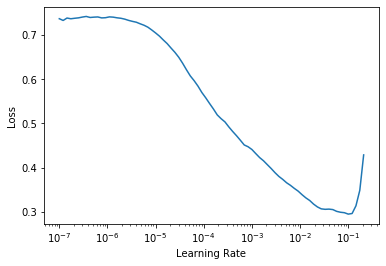

In [14]:
learn.lr_find()

In [11]:
do_fit(learn, 10, 1e-3)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.105431,0.202557,0.946197,0.863059,02:43
1,0.079721,0.089342,0.971318,0.948883,02:50
2,0.071013,0.076777,0.974836,0.956102,02:54
3,0.064468,0.076349,0.975441,0.957438,02:53
4,0.064089,0.073510,0.976886,0.955974,02:53
5,0.057723,0.072075,0.977476,0.958762,02:53
6,0.056094,0.071236,0.977389,0.958050,02:53
7,0.054675,0.068767,0.978155,0.958037,02:51
8,0.053202,0.067563,0.978571,0.958877,02:52
9,0.053077,0.066953,0.978702,0.958775,02:53


In [ ]:
learn.load(f'runs/{name}-1')
do_fit(learn, 4, 1e-4)
learn.save(f'runs/{name}-2')

## Testing

In [9]:
learn.dls = get_3d_dls_feat(Meta.df_tst, path=path_appfeat512_tst, bs=32, test=True, meta=True)

In [10]:
sub_fn = f'subm/{name}'
learn.load(f'runs/{name}-1')

In [11]:
preds,targs = learn.get_preds()
preds.shape, preds.min(), preds.max()

(torch.Size([121232, 6]), tensor(2.3356e-09), tensor(1.0000))

In [12]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [13]:
api.competition_submit(f'{sub_fn}.csv', name, 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:02<00:00, 11.5MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [18]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14464928,
 'totalBytes': 27277209,
 'date': '2020-02-12T21:33:45.873Z',
 'description': 'train3d_adj_feat_lstm_2ndplace_meta_album_384',
 'errorDescription': None,
 'fileName': 'train3d_adj_feat_lstm_2ndplace_meta_album_384.csv',
 'publicScore': '0.70463',
 'privateScore': '0.05423',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14464928/14464928.raw'}